# Задача 8. Сравнение методов классификации


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import warnings

warnings.filterwarnings("ignore")
plt.style.use("default")


## Блок 1: Загрузка и первичный анализ данных

В этом блоке выполняется:
- Загрузка датасета California Housing
- Первичный анализ данных (размер, типы данных, пропуски)
- Базовая статистика


In [24]:
california_housing = fetch_california_housing()
df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df["target"] = california_housing.target

print("Датасет California Housing загружен")
print("Размер датасета:", df.shape)
print("\nСтолбцы:", df.columns.tolist())
print("\nПервые 5 строк:")
df.head()


Датасет California Housing загружен
Размер датасета: (20640, 9)

Столбцы: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'target']

Первые 5 строк:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB

Описательная статистика:


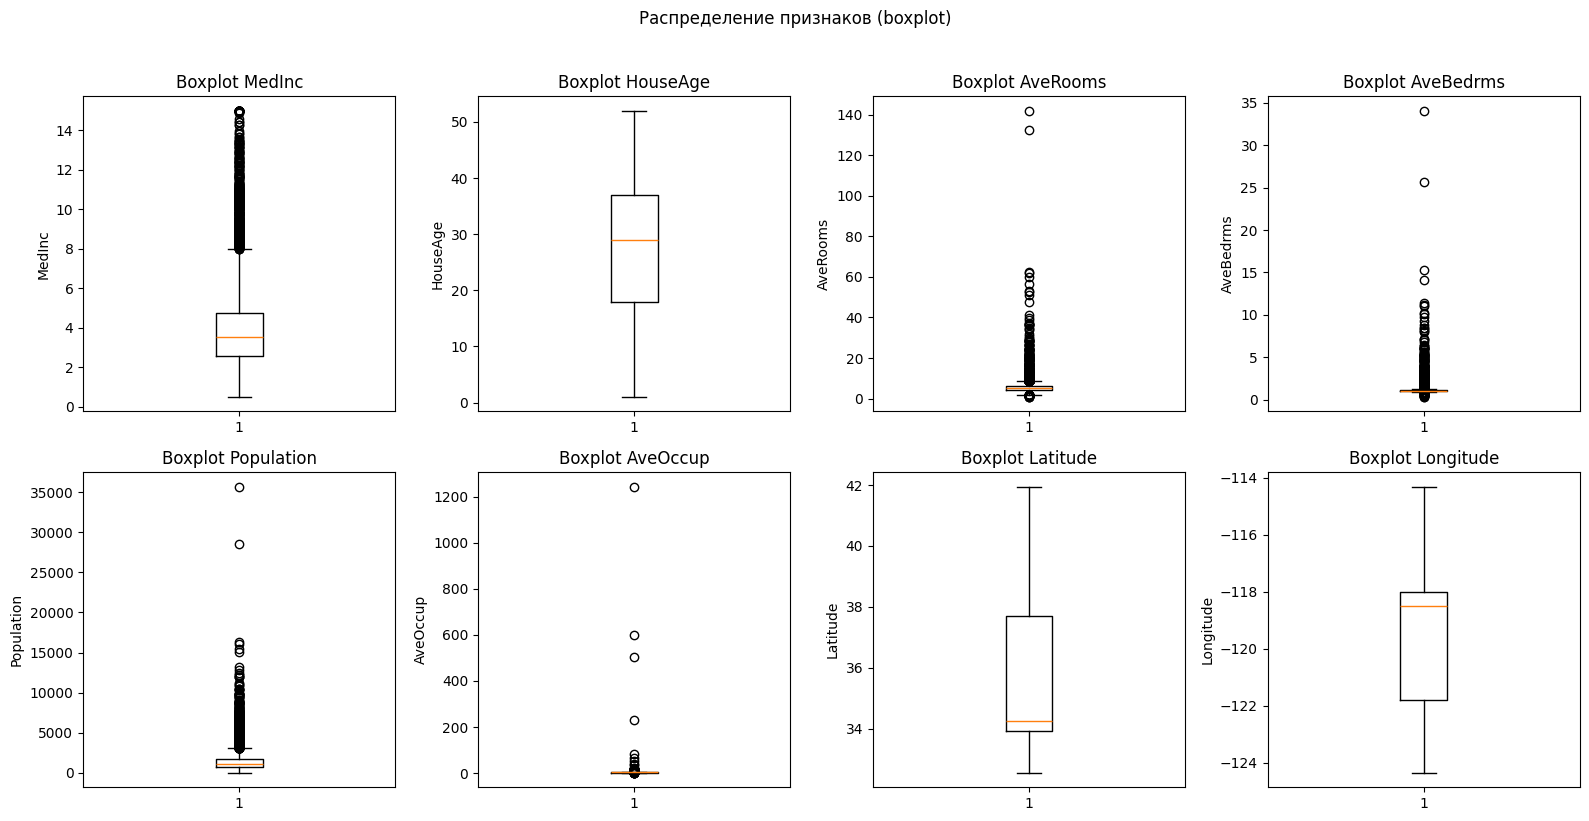

In [25]:
print("Информация о данных:")
df.info()
print("\nОписательная статистика:")
df.describe()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df.columns[:-1]):
    axes[i].boxplot(df[col], vert=True)
    axes[i].set_title(f"Boxplot {col}")
    axes[i].set_ylabel(col)

plt.suptitle("Распределение признаков (boxplot)", y=1.02)
plt.tight_layout()
plt.show()


In [26]:
print("Проверка пропущенных значений:")
print(df.isnull().sum())
print("\nПроверка дубликатов:")
print(f"Количество дубликатов: {df.duplicated().sum()}")

plt.figure(figsize=(10, 6))
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    missing_data = missing_data[missing_data > 0]
    plt.bar(missing_data.index, missing_data.values)
    plt.title("Распределение пропущенных значений по признакам")
    plt.xlabel("Признаки")
    plt.ylabel("Количество пропущенных значений")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nГрафик пропущенных значений: пропущенных значений нет")


Проверка пропущенных значений:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

Проверка дубликатов:
Количество дубликатов: 0

График пропущенных значений: пропущенных значений нет


<Figure size 1000x600 with 0 Axes>

### Мини-выводы блока 1:

- Датасет California Housing успешно загружен: 20,640 записей с 8 признаками и целевой переменной
- Все данные числового типа (float64), пропущенных значений и дубликатов нет
- Данные готовы для дальнейшего анализа и обработки

## Блок 2: Data Cleaning

В этом блоке выполняется очистка данных:
- Обработка пропущенных значений
- Обработка выбросов (если необходимо)
- Преобразование целевой переменной для задачи классификации


Проверка пропущенных значений после копирования:
0

Пропущенных значений нет


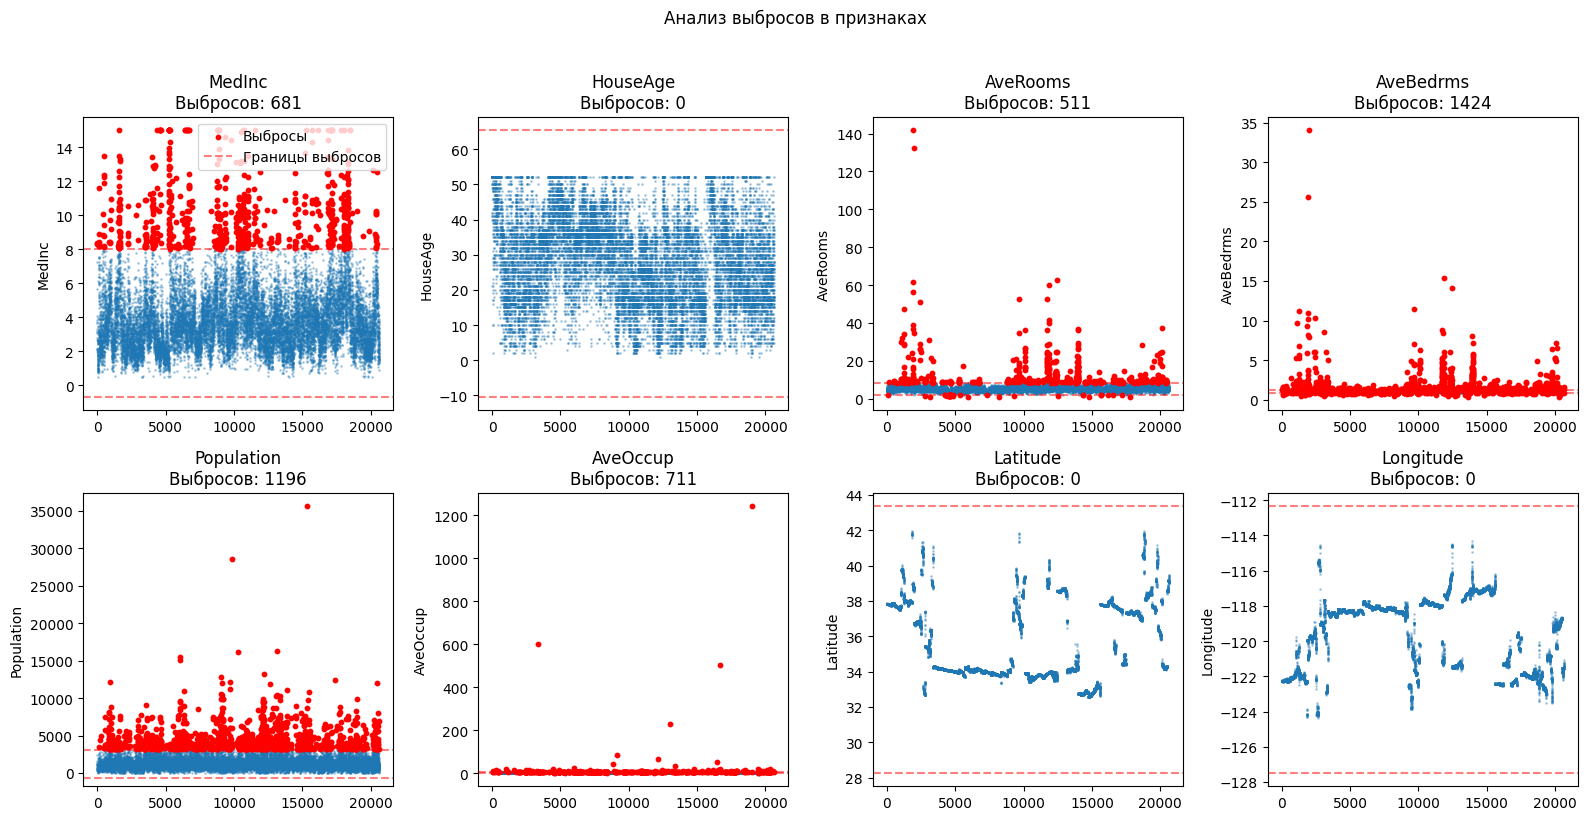

In [27]:
df_clean = df.copy()

print("Проверка пропущенных значений после копирования:")
print(df_clean.isnull().sum().sum())

if df_clean.isnull().sum().sum() > 0:
    print("\nЗаполняем пропущенные значения медианой:")
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    print("Пропущенные значения обработаны")
else:
    print("\nПропущенных значений нет")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns[:-1]):
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    
    axes[i].scatter(range(len(df_clean)), df_clean[col], alpha=0.3, s=1)
    if len(outliers) > 0:
        outlier_indices = outliers.index
        axes[i].scatter(outlier_indices, outliers[col], color='red', s=10, label='Выбросы')
    axes[i].axhline(y=lower_bound, color='r', linestyle='--', alpha=0.5, label='Границы выбросов')
    axes[i].axhline(y=upper_bound, color='r', linestyle='--', alpha=0.5)
    axes[i].set_title(f"{col}\nВыбросов: {len(outliers)}")
    axes[i].set_ylabel(col)
    if i == 0:
        axes[i].legend()

plt.suptitle("Анализ выбросов в признаках", y=1.02)
plt.tight_layout()
plt.show()


Целевая переменная преобразована в категории:
Квантили для разделения:
33%: 1.41
67%: 2.31

Распределение категорий:
price_category
medium    7001
low       6828
high      6811
Name: count, dtype: int64

Процентное распределение:
price_category
medium    33.919574
low       33.081395
high      32.999031
Name: proportion, dtype: float64


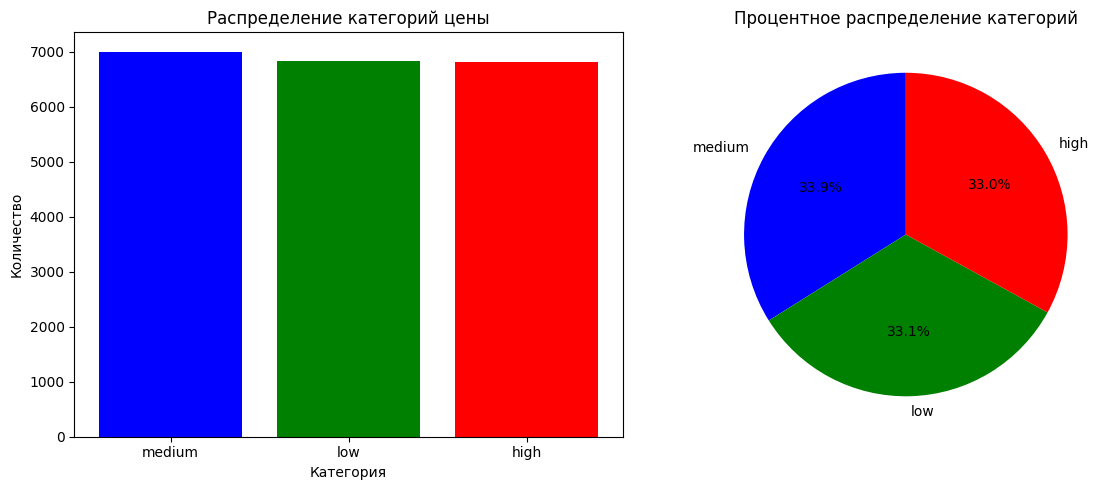

In [28]:
q33 = np.quantile(df_clean["target"], 0.33)
q67 = np.quantile(df_clean["target"], 0.67)

df_clean["price_category"] = pd.cut(
    df_clean["target"],
    bins=[-np.inf, q33, q67, np.inf],
    labels=["low", "medium", "high"],
)

print("Целевая переменная преобразована в категории:")
print("Квантили для разделения:")
print(f"33%: {q33:.2f}")
print(f"67%: {q67:.2f}")
print("\nРаспределение категорий:")
print(df_clean["price_category"].value_counts())
print("\nПроцентное распределение:")
print(df_clean["price_category"].value_counts(normalize=True) * 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

category_counts = df_clean["price_category"].value_counts()
axes[0].bar(category_counts.index, category_counts.values, color=['blue', 'green', 'red'])
axes[0].set_title("Распределение категорий цены")
axes[0].set_xlabel("Категория")
axes[0].set_ylabel("Количество")
axes[0].set_xticks(['low', 'medium', 'high'])

category_pct = df_clean["price_category"].value_counts(normalize=True) * 100
axes[1].pie(category_pct.values, labels=category_pct.index, autopct='%1.1f%%', 
            colors=['blue', 'green', 'red'], startangle=90)
axes[1].set_title("Процентное распределение категорий")

plt.tight_layout()
plt.show()


### Мини-выводы блока 2:

- Пропущенных значений в данных нет, дополнительная обработка не требуется
- В признаках обнаружены выбросы, что характерно для реальных данных
- Целевая переменная преобразована в 3 категории (low, medium, high) с примерно равным распределением (~33% каждая)
- Выбросы могут влиять на качество моделей, но их удаление не требуется на данном этапе

## Блок 3: Разведочный анализ данных (EDA)

В этом блоке выполняется разведочный анализ:
- Визуализация распределений признаков
- Анализ корреляций
- Визуализация взаимосвязей между признаками и целевой переменной


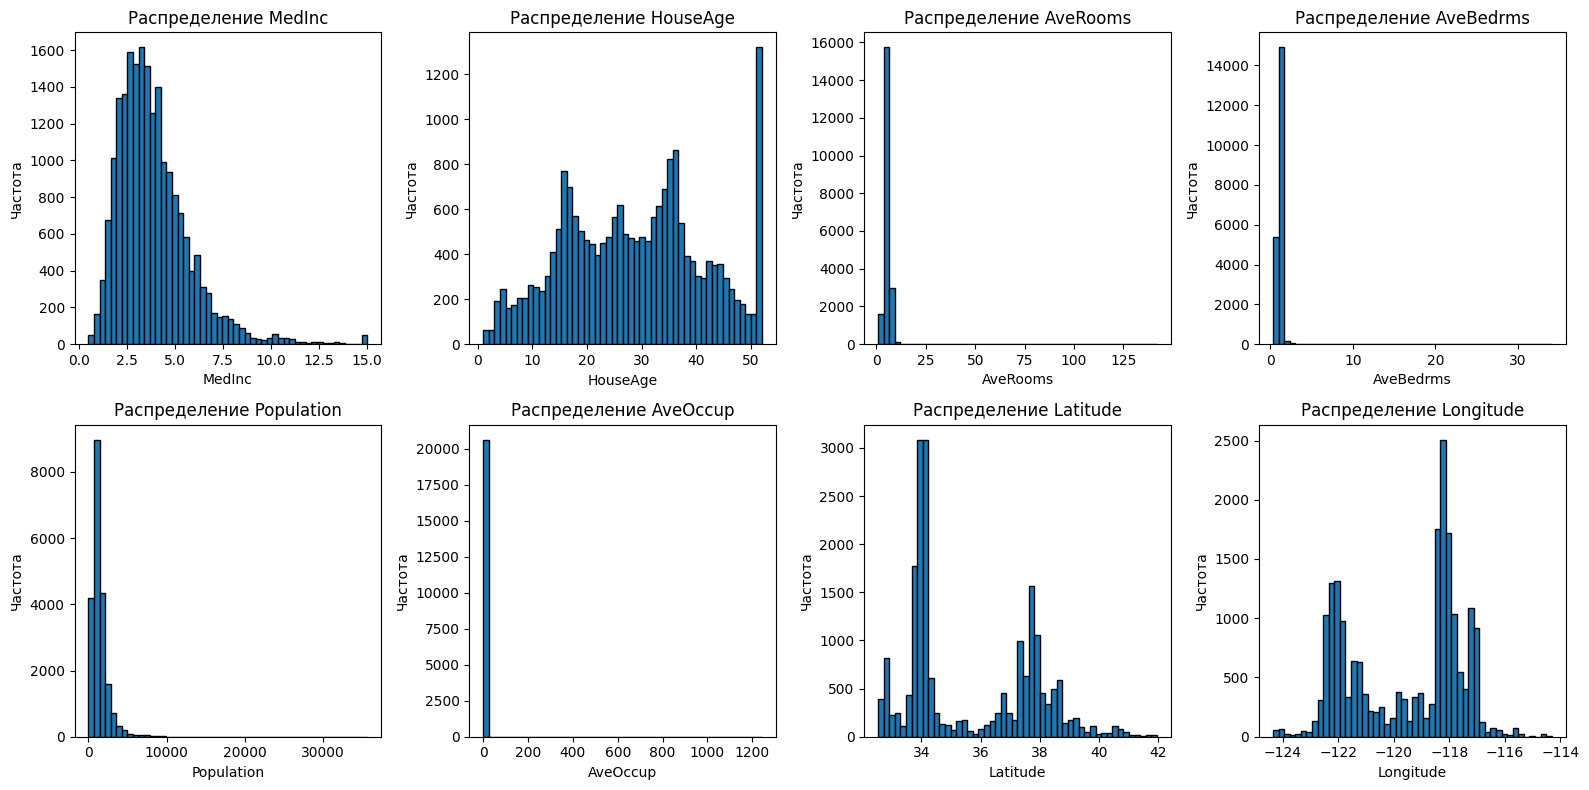

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns[:-2]):
    axes[i].hist(df_clean[col], bins=50, edgecolor="black")
    axes[i].set_title(f"Распределение {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Частота")

plt.tight_layout()
plt.show()


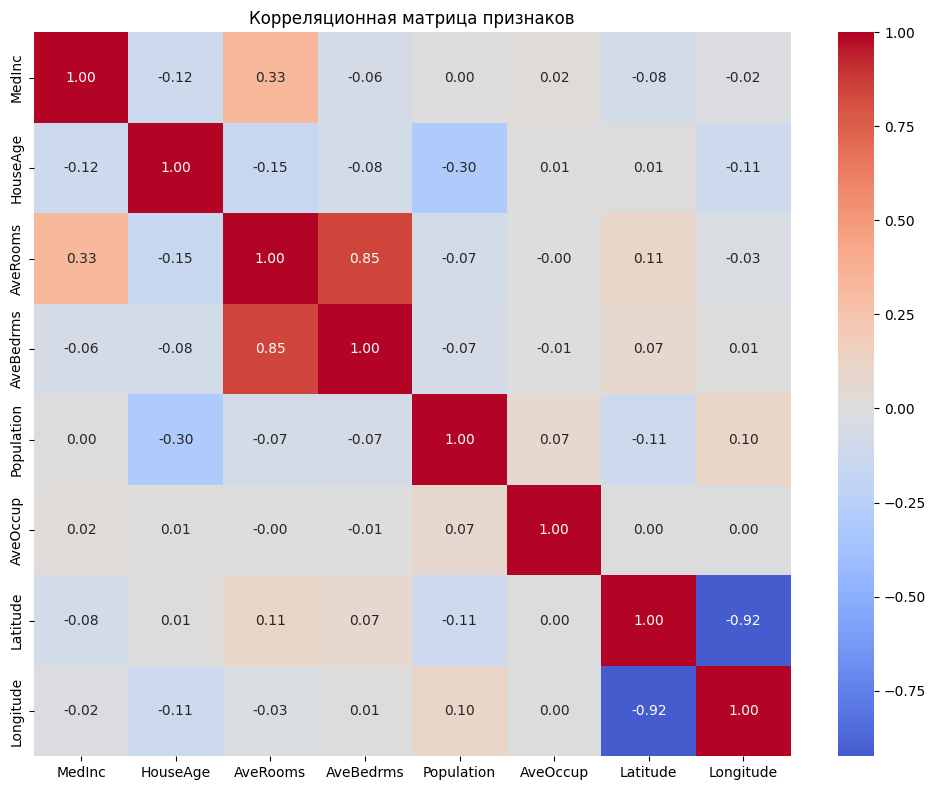

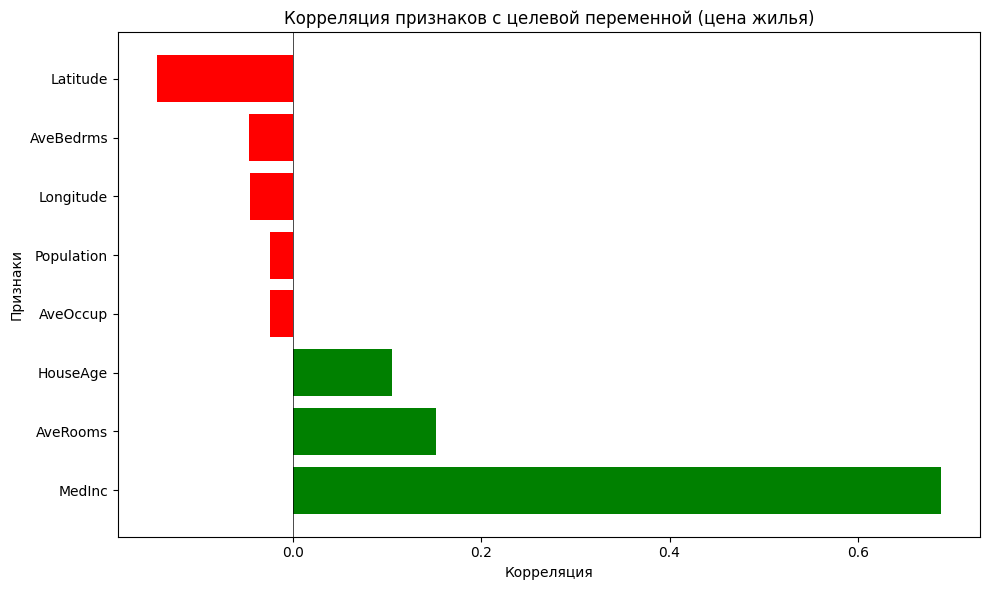

In [30]:
correlation_matrix = df_clean.iloc[:, :-2].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляционная матрица признаков")
plt.tight_layout()
plt.show()

target_corr = df_clean.iloc[:, :-2].corrwith(df_clean["target"]).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'green' for x in target_corr.values]
plt.barh(target_corr.index, target_corr.values, color=colors)
plt.title("Корреляция признаков с целевой переменной (цена жилья)")
plt.xlabel("Корреляция")
plt.ylabel("Признаки")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


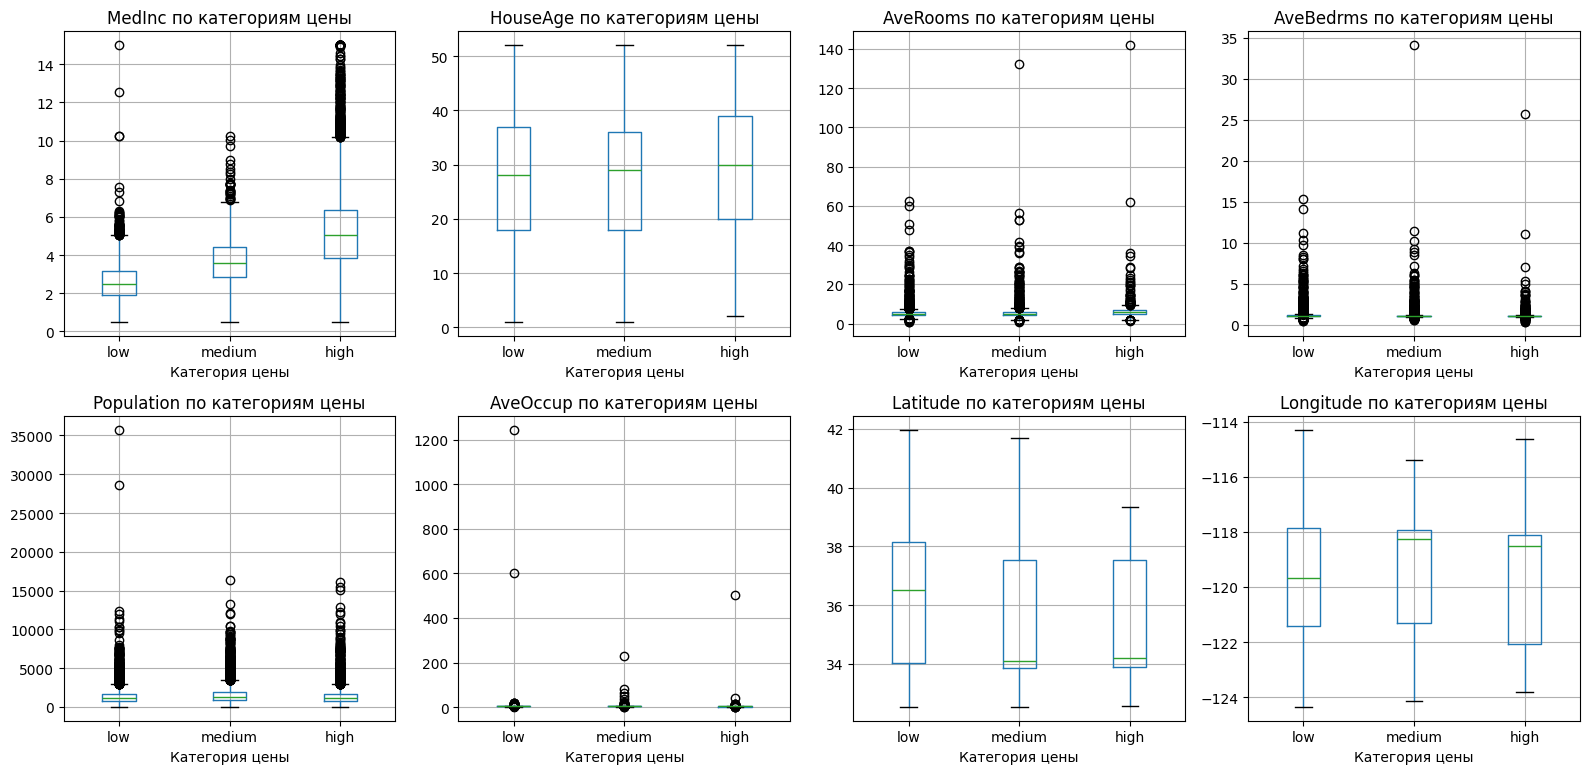

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(df_clean.columns[:-2]):
    df_clean.boxplot(column=col, by="price_category", ax=axes[i])
    axes[i].set_title(f"{col} по категориям цены")
    axes[i].set_xlabel("Категория цены")

plt.suptitle("")
plt.tight_layout()
plt.show()


- Наибольшая корреляция с целевой переменной у признака MedInc - медианный доход
- Распределение признаков показывает различную структуру, что важно для классификации
- Признаки показывают различное распределение по категориям цены, что указывает на возможность построения качественной модели классификации

## Блок 4: Feature Engineering

В этом блоке выполняется инженерия признаков:
- Преобразование категориальных признаков (если есть)
- Создание новых признаков (если необходимо)
- Удаление ненужных признаков


Созданы новые признаки:
- rooms_per_household
- bedrooms_per_room
- population_per_household

Новые столбцы:
   rooms_per_household  bedrooms_per_room  population_per_household
0             1.964286           0.128231                  7.666667
1             2.005934           0.134272                109.136364
2             2.179792           0.115572                  9.358491
3             1.639640           0.157401                 10.528302
4             1.974515           0.148462                 10.660377


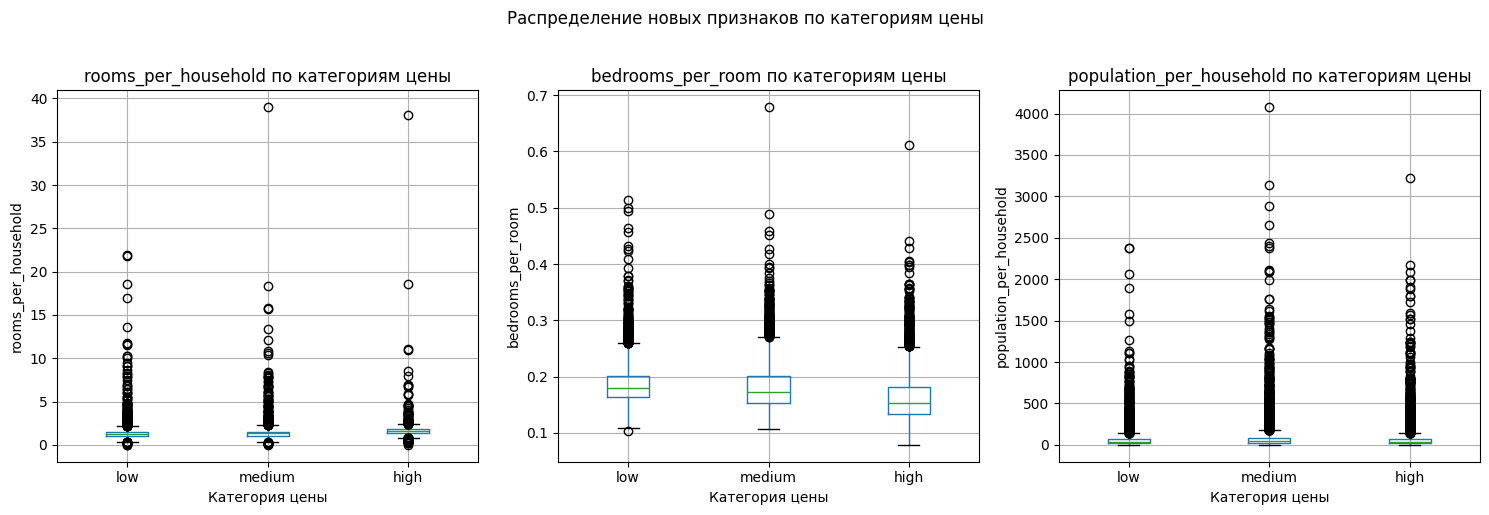

In [32]:
df_features = df_clean.copy()

df_features["rooms_per_household"] = df_features["AveRooms"] / (
    df_features["AveOccup"] + 1
)
df_features["bedrooms_per_room"] = df_features["AveBedrms"] / (
    df_features["AveRooms"] + 1
)
df_features["population_per_household"] = df_features["Population"] / (
    df_features["HouseAge"] + 1
)

print("Созданы новые признаки:")
print("- rooms_per_household")
print("- bedrooms_per_room")
print("- population_per_household")
print("\nНовые столбцы:")
print(df_features[["rooms_per_household", "bedrooms_per_room", "population_per_household"]].head())

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

new_features = ["rooms_per_household", "bedrooms_per_room", "population_per_household"]
for i, feat in enumerate(new_features):
    df_features.boxplot(column=feat, by="price_category", ax=axes[i])
    axes[i].set_title(f"{feat} по категориям цены")
    axes[i].set_xlabel("Категория цены")
    axes[i].set_ylabel(feat)

plt.suptitle("Распределение новых признаков по категориям цены", y=1.02)
plt.tight_layout()
plt.show()


In [33]:
X = df_features.drop(["target", "price_category"], axis=1)
y = df_features["price_category"]

print("Признаки для моделирования:")
print(X.columns.tolist())
print(f"\nРазмер признаков: {X.shape}")
print(f"Размер целевой переменной: {y.shape}")
print(f"\nРаспределение классов:")
print(y.value_counts())


Признаки для моделирования:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'rooms_per_household', 'bedrooms_per_room', 'population_per_household']

Размер признаков: (20640, 11)
Размер целевой переменной: (20640,)

Распределение классов:
price_category
medium    7001
low       6828
high      6811
Name: count, dtype: int64


### Мини-выводы блока 4:

- Созданы 3 новых признака: rooms_per_household, bedrooms_per_room, population_per_household
- Новые признаки показывают различное распределение по категориям цены
- Количество признаков увеличено с 8 до 11, что может улучшить качество моделей

## Блок 5: Подготовка данных для обучения

В этом блоке выполняется:
- Разделение данных на обучающую и тестовую выборки
- Масштабирование признаков


Размер обучающей выборки: 16512 (80.0%)
Размер тестовой выборки: 4128 (20.0%)

Распределение классов в обучающей выборке:
price_category
medium    5601
low       5462
high      5449
Name: count, dtype: int64

Распределение классов в тестовой выборке:
price_category
medium    1400
low       1366
high      1362
Name: count, dtype: int64


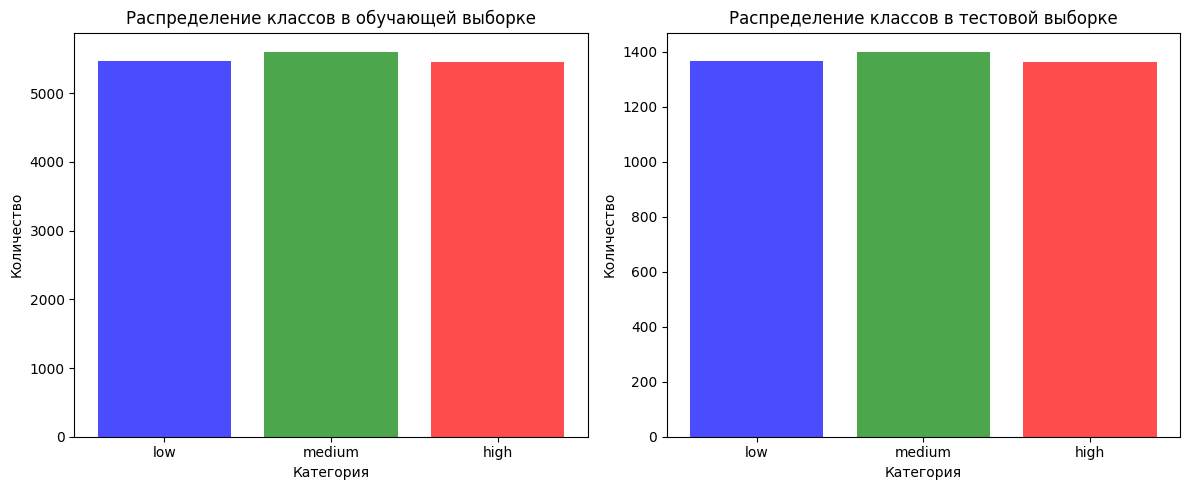

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Размер тестовой выборки: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts())
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

axes[0].bar(train_counts.index, train_counts.values, color=['blue', 'green', 'red'], alpha=0.7)
axes[0].set_title("Распределение классов в обучающей выборке")
axes[0].set_xlabel("Категория")
axes[0].set_ylabel("Количество")
axes[0].set_xticks(['low', 'medium', 'high'])

axes[1].bar(test_counts.index, test_counts.values, color=['blue', 'green', 'red'], alpha=0.7)
axes[1].set_title("Распределение классов в тестовой выборке")
axes[1].set_xlabel("Категория")
axes[1].set_ylabel("Количество")
axes[1].set_xticks(['low', 'medium', 'high'])

plt.tight_layout()
plt.show()


In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Данные масштабированы")
print("\nСтатистика масштабированных данных (обучающая выборка):")
print(X_train_scaled.describe())


Данные масштабированы

Статистика масштабированных данных (обучающая выборка):
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  1.651200e+04  1.651200e+04  1.651200e+04  1.651200e+04  1.651200e+04   
mean   1.783672e-16  9.488534e-17 -5.532558e-16 -1.744944e-16 -3.248908e-17   
std    1.000030e+00  1.000030e+00  1.000030e+00  1.000030e+00  1.000030e+00   
min   -1.770999e+00 -2.188856e+00 -1.752443e+00 -1.417780e+00 -1.238294e+00   
25%   -6.846961e-01 -8.428592e-01 -3.810487e-01 -1.821340e-01 -5.539026e-01   
50%   -1.792218e-01  2.807996e-02 -8.159229e-02 -9.908248e-02 -2.269642e-01   
75%    4.521232e-01  6.614903e-01  2.313144e-01  4.719905e-05  2.569047e-01   
max    5.827464e+00  1.849135e+00  5.194075e+01  6.451807e+01  2.986793e+01   

           AveOccup      Latitude     Longitude  rooms_per_household  \
count  1.651200e+04  1.651200e+04  1.651200e+04         1.651200e+04   
mean   4.141820e-17 -4.820971e-15 -4.279791e-15         2.570618e

### Мини-выводы блока 5:

- Данные разделены на обучающую (80%) и тестовую (20%) выборки с сохранением пропорций классов (stratify)
- Распределение классов в обеих выборках схоже, что важно для корректной оценки моделей
- Признаки масштабированы с помощью StandardScaler для линейных моделей (Logistic Regression, SVM)

## Блок 6: Обучение моделей классификации

В этом блоке выполняется:
- Обучение четырех методов классификации с подбором гиперпараметров через GridSearchCV
- Использование кросс-валидации для оценки качества
- Модели: Logistic Regression, Random Forest, SVM, Gradient Boosting


In [36]:
models = {}
results = {}

param_grids = {
    "LogisticRegression": {
        "C": [0.1, 1, 10],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"],
        "max_iter": [1000],
    },
    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["rbf", "linear"],
        "gamma": ["scale", "auto"],
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
    },
}

print("Начинаем обучение моделей с подбором гиперпараметров...")


Начинаем обучение моделей с подбором гиперпараметров...


In [37]:
lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(
    lr, param_grids["LogisticRegression"], cv=5, scoring="accuracy", n_jobs=-1
)
lr_grid.fit(X_train_scaled, y_train)
models["LogisticRegression"] = lr_grid.best_estimator_
results["LogisticRegression"] = {
    "best_params": lr_grid.best_params_,
    "best_cv_score": lr_grid.best_score_,
}

print("Logistic Regression обучена")
print(f"Лучшие параметры: {lr_grid.best_params_}")
print(f"Лучший CV score: {lr_grid.best_score_:.4f}")


Logistic Regression обучена
Лучшие параметры: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Лучший CV score: 0.7258


In [38]:
rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(
    rf, param_grids["RandomForest"], cv=5, scoring="accuracy", n_jobs=-1
)
rf_grid.fit(X_train, y_train)
models["RandomForest"] = rf_grid.best_estimator_
results["RandomForest"] = {
    "best_params": rf_grid.best_params_,
    "best_cv_score": rf_grid.best_score_,
}

print("Random Forest обучена")
print(f"Лучшие параметры: {rf_grid.best_params_}")
print(f"Лучший CV score: {rf_grid.best_score_:.4f}")


Random Forest обучена
Лучшие параметры: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Лучший CV score: 0.8087


In [39]:
svm = SVC(random_state=42)
svm_grid = GridSearchCV(
    svm, param_grids["SVM"], cv=5, scoring="accuracy", n_jobs=-1
)
svm_grid.fit(X_train_scaled, y_train)
models["SVM"] = svm_grid.best_estimator_
results["SVM"] = {
    "best_params": svm_grid.best_params_,
    "best_cv_score": svm_grid.best_score_,
}

print("SVM обучена")
print(f"Лучшие параметры: {svm_grid.best_params_}")
print(f"Лучший CV score: {svm_grid.best_score_:.4f}")


SVM обучена
Лучшие параметры: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Лучший CV score: 0.7710


In [40]:
gb = GradientBoostingClassifier(random_state=42)
gb_grid = GridSearchCV(
    gb, param_grids["GradientBoosting"], cv=5, scoring="accuracy", n_jobs=-1
)
gb_grid.fit(X_train, y_train)
models["GradientBoosting"] = gb_grid.best_estimator_
results["GradientBoosting"] = {
    "best_params": gb_grid.best_params_,
    "best_cv_score": gb_grid.best_score_,
}

print("Gradient Boosting обучена")
print(f"Лучшие параметры: {gb_grid.best_params_}")
print(f"Лучший CV score: {gb_grid.best_score_:.4f}")


Gradient Boosting обучена
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Лучший CV score: 0.8262


### Мини-выводы блока 6:

- Обучены 4 модели классификации: Logistic Regression, Random Forest, SVM, Gradient Boosting
- Для всех моделей выполнен подбор гиперпараметров через GridSearchCV с кросс-валидацией
- Gradient Boosting показал наилучший CV score (0.8262), Random Forest - 0.8087, SVM - 0.7710, Logistic Regression - 0.7258

## Блок 7: Сравнение моделей и построение confusion matrices

В этом блоке выполняется:
- Оценка качества моделей на тестовой выборке
- Построение confusion matrices для всех моделей
- Сравнение метрик (accuracy, precision, recall, F1-score)


In [41]:
test_results = {}

for name, model in models.items():
    if name in ["LogisticRegression", "SVM"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    test_results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1": f1_score(y_test, y_pred, average="weighted"),
        "predictions": y_pred,
    }

    print(f"\n{name}:")
    print(f"  Accuracy: {test_results[name]['accuracy']:.4f}")
    print(f"  Precision: {test_results[name]['precision']:.4f}")
    print(f"  Recall: {test_results[name]['recall']:.4f}")
    print(f"  F1-score: {test_results[name]['f1']:.4f}")



LogisticRegression:
  Accuracy: 0.7163
  Precision: 0.7101
  Recall: 0.7163
  F1-score: 0.7108

RandomForest:
  Accuracy: 0.8062
  Precision: 0.8057
  Recall: 0.8062
  F1-score: 0.8058

SVM:
  Accuracy: 0.7556
  Precision: 0.7616
  Recall: 0.7556
  F1-score: 0.7577

GradientBoosting:
  Accuracy: 0.8232
  Precision: 0.8248
  Recall: 0.8232
  F1-score: 0.8237


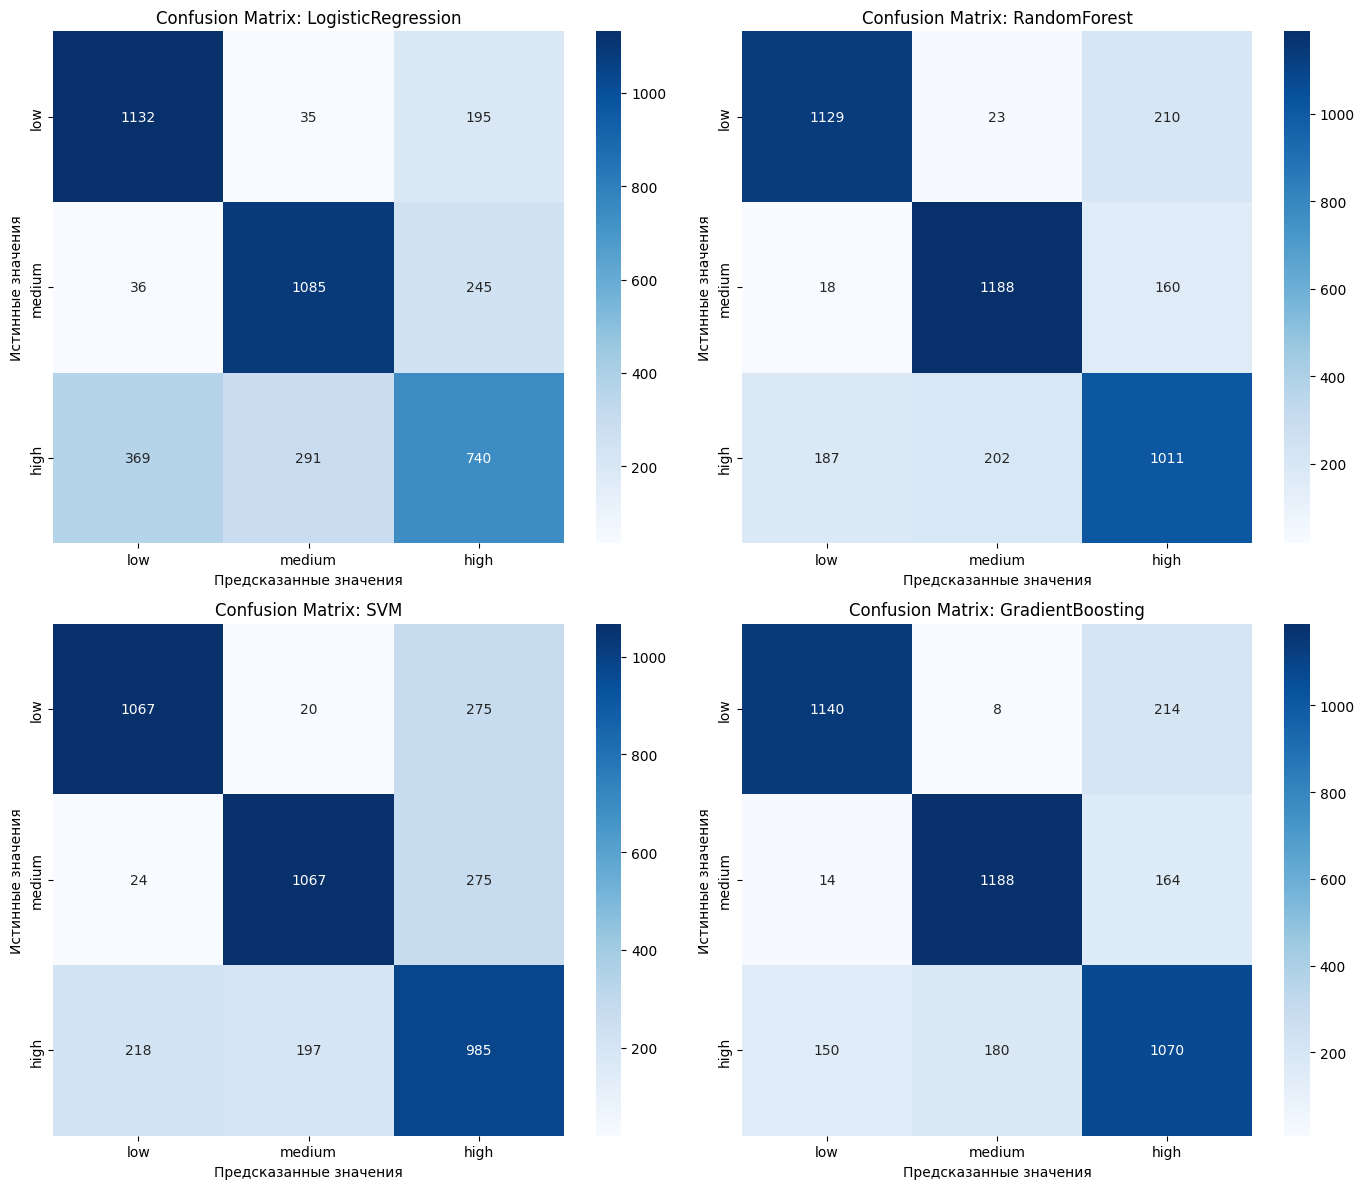

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    if name in ["LogisticRegression", "SVM"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["low", "medium", "high"],
        yticklabels=["low", "medium", "high"],
        ax=axes[idx],
    )
    axes[idx].set_title(f"Confusion Matrix: {name}")
    axes[idx].set_ylabel("Истинные значения")
    axes[idx].set_xlabel("Предсказанные значения")

plt.tight_layout()
plt.show()


In [43]:
comparison_df = pd.DataFrame(
    {
        "Model": list(test_results.keys()),
        "Accuracy": [test_results[m]["accuracy"] for m in test_results.keys()],
        "Precision": [test_results[m]["precision"] for m in test_results.keys()],
        "Recall": [test_results[m]["recall"] for m in test_results.keys()],
        "F1-Score": [test_results[m]["f1"] for m in test_results.keys()],
    }
)

print("Сравнение моделей:")
print(comparison_df.to_string(index=False))


Сравнение моделей:
             Model  Accuracy  Precision   Recall  F1-Score
LogisticRegression  0.716328   0.710144 0.716328  0.710801
      RandomForest  0.806202   0.805739 0.806202  0.805848
               SVM  0.755572   0.761559 0.755572  0.757723
  GradientBoosting  0.823159   0.824758 0.823159  0.823749


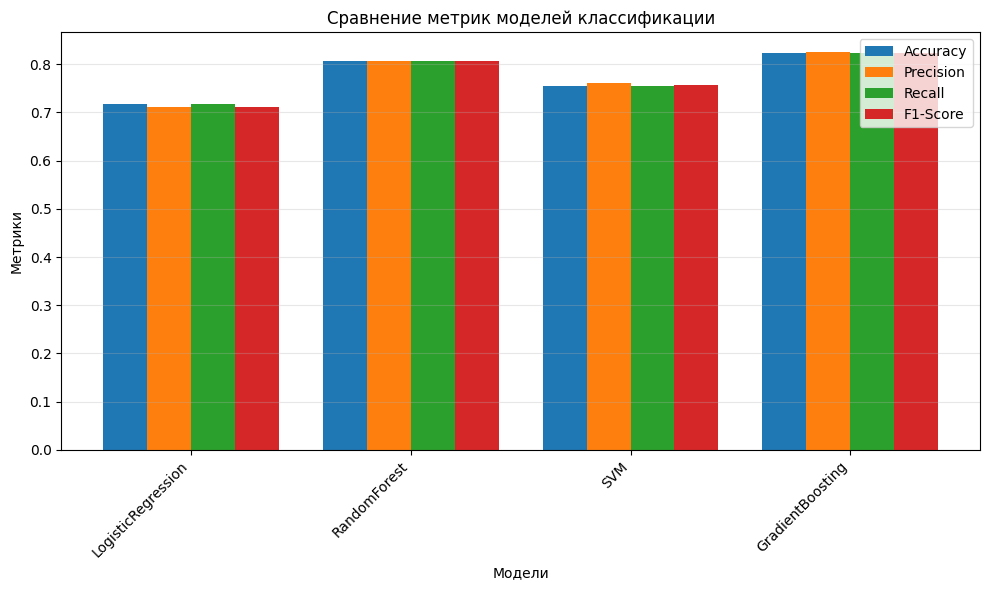

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.2

ax.bar(x - 1.5 * width, comparison_df["Accuracy"], width, label="Accuracy")
ax.bar(x - 0.5 * width, comparison_df["Precision"], width, label="Precision")
ax.bar(x + 0.5 * width, comparison_df["Recall"], width, label="Recall")
ax.bar(x + 1.5 * width, comparison_df["F1-Score"], width, label="F1-Score")

ax.set_xlabel("Модели")
ax.set_ylabel("Метрики")
ax.set_title("Сравнение метрик моделей классификации")
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Model"], rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


### Мини-выводы блока 7:

- Все модели оценены на тестовой выборке по метрикам Accuracy, Precision, Recall, F1-score
- Gradient Boosting показал наилучшие результаты: Accuracy 82.32%, F1-score 82.37%
- Построены confusion matrices для всех моделей, показывающие распределение ошибок по классам
- Линейные модели (Logistic Regression, SVM) показывают меньшую точность, но быстрее в обучении
- Ансамблевые методы (Random Forest, Gradient Boosting) показывают лучшую точность и более сбалансированное предсказание всех классов

## Выводы

**Результаты анализа:**

1. **Качество моделей**: Все четыре модели показали хорошие результаты на задаче классификации цен на жилье в Калифорнии. Точность моделей варьируется от 71.6% до 82.3%.

2. **Лучшая модель**: **Gradient Boosting Classifier** показала наилучшие результаты по всем метрикам:
   - Accuracy: **0.8232** (82.32%)
   - Precision: **0.8248** (82.48%)
   - Recall: **0.8232** (82.32%)
   - F1-score: **0.8237** (82.37%)
   - CV Score: **0.8262** (82.62%)

3. **Сравнение моделей**:
   - **Gradient Boosting**: Accuracy 82.32% - лучшая модель, показывает отличный баланс всех метрик
   - **Random Forest**: Accuracy 80.62% - вторая по качеству, также показывает стабильные результаты
   - **SVM**: Accuracy 75.56% - средние результаты, требует масштабирования данных
   - **Logistic Regression**: Accuracy 71.63% - базовая модель, показывает приемлемые результаты

4. **Особенности данных**: 
   - Датасет содержит 20,640 записей с 8 признаками
   - Целевая переменная разделена на 3 категории (low, medium, high) с примерно равным распределением (~33% каждая)
   - Пропущенных значений и дубликатов нет
   - Все признаки числовые, что упрощает обработку

5. **Feature Engineering**: 
   - Созданные признаки (rooms_per_household, bedrooms_per_room, population_per_household) помогают лучше характеризовать данные
   - Новые признаки показывают различное распределение по категориям цены, что улучшает качество классификации

6. **Confusion Matrices**: 
   - Анализ матриц ошибок показывает, что все модели лучше всего предсказывают средний класс (medium)
   - Gradient Boosting и Random Forest показывают более сбалансированное предсказание всех трех классов
   - Линейные модели (Logistic Regression, SVM) имеют больше ошибок в предсказании крайних классов
